# Dogs versus Cats


Importamos las librerias para poder entrenar el modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from time import time
# tensorboard --logdir=logs/ --host localhost --port 8088

print(f'TensorFlow Version - {tf.__version__}')
print(f'Keras Version - {tf.keras.__version__}')

TensorFlow Version - 2.8.2
Keras Version - 2.8.0


Configuramos los siguientes parámetros para entrenar el modelo

In [ ]:
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'
IMG_SIZE = 50
LR = 0.0003
BATCH_SIZE = 32

MODEL_NAME = 'dogs_cats_LR-{}_MODEL-{}.h5'.format(LR,'CovNet-128(2)-64(2)-32(2)-512-128-1')
MODEL_PATH = os.path.join('saved_models',MODEL_NAME)

Funciones helper

In [ ]:
def get_model(saved=True):
    """This method returns the model used.
    Returns a saved model if MODEL_NAME is found.
    CovNet Architecture
    
    Keyword Arguments:
    saved - Get the saved model from the MODEL_PATH if exists.(default True)
    
    Returns:
    model - The complete uncompiled Keras model.
    """
    tf.compat.v1.reset_default_graph()
    
    if os.path.isfile(MODEL_PATH) and saved :
        print("Loading saved model {}".format(MODEL_NAME))
        return load_model(MODEL_PATH)
    
    # Declaring model
    model = Sequential()

    # 1st Block
    model.add(Conv2D(input_shape=(IMG_SIZE, IMG_SIZE, 1),filters=128, kernel_size=5, strides=1,padding='same',name = 'blk1_conv1'))
    model.add(Conv2D(filters=128, kernel_size=5, strides=1,padding='same',name = 'blk1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,name = 'blk1_mxPool'))

    # 2nd Block
    model.add(Conv2D(filters=64, kernel_size=5, strides=1,padding='same',name = 'blk2_conv1'))
    model.add(Conv2D(filters=64, kernel_size=5, strides=1,padding='same',name = 'blk2_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,name = 'blk2_mxPool'))
    
    # 3rd Block
    model.add(Conv2D(filters=32, kernel_size=5, strides=1,padding='same',name = 'blk3_conv1'))
    model.add(Conv2D(filters=32, kernel_size=5, strides=1,padding='same',name = 'blk3_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2,name = 'blk3_mxPool'))

    # 4th Block - FC Block
    dr_rate = 0.35
    model.add(Flatten(name = 'blk4_flatten'))
    model.add(Dropout(dr_rate,name = 'blk4_droupout1'))
    model.add(Dense(512, activation='relu',name = 'blk4_dense1'))
    model.add(Dropout(dr_rate,name = 'blk4_droupout2'))
    model.add(Dense(128, activation='relu',name = 'blk4_dense2'))
    model.add(Dropout(dr_rate,name = 'blk4_droupout3'))
    model.add(Dense(1, activation='sigmoid',name = 'blk4_dense3'))

    return model

def get_label(img):
    """Returns the label for an image.
    
    Keyword Arguments:
    img - The filename of the image whose label we want to get.
    
    Returns:
    list object - The respective label for dog or cat. (dog = 1, cat = 0)
    """
    word = img.split('.')[0]
    if word == 'cat':
        return [0]
    else:
        return [1]
  
def get_training_data():
    """Returns the training data from TRAIN_DIR.
    Images are read in grayscale format and resized to IMG_SIZE dimension square.
    The whole data is saved with numpy in .npy format for quick loading for future purpose.
    """
    training_data = []
    if os.path.isfile('training_data_{}.npy'.format(IMG_SIZE)):
        return np.load('training_data_{}.npy'.format(IMG_SIZE))
    else:
        for img in tqdm(os.listdir(TRAIN_DIR)):
            label = get_label(img)
            path = os.path.join(TRAIN_DIR,img)
            img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
            img = img/255
            training_data.append([np.array(img),np.array(label)])
        shuffle(training_data)
        np.save('training_data_{}.npy'.format(IMG_SIZE),training_data)
        return np.array(training_data)



def get_testing_data():
    """Returns the testing data from TEST_DIR.
    Images are read in grayscale format and resized to IMG_SIZE dimension square.
    The whole data is saved with numpy in .npy format for quick loading for future purpose.
    """
    testing_data = []
    if os.path.isfile('testing_data_{}.npy'.format(IMG_SIZE)):
        return np.load('testing_data_{}.npy'.format(IMG_SIZE))
    else:
        for img in tqdm(os.listdir(TEST_DIR)):
            img_id = int(img.split('.')[0])
            path = os.path.join(TEST_DIR,img)
            img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
            img = img/255
            testing_data.append([np.array(img),img_id])
        testing_data.sort(key = lambda x: x[1])
        np.save('testing_data_{}.npy'.format(IMG_SIZE),testing_data)
        return np.array(testing_data)

Obtencion de los datos y definicion de los sets

In [ ]:
! wget https://github.com/don-charlie-pc/dogs-vs-cats/releases/download/dataset/test.zip
! wget https://github.com/don-charlie-pc/dogs-vs-cats/releases/download/dataset/train.zip

! unzip test.zip
! unzip train.zip

! mkdir -p data
! mv test data/
! mv train data/

! ls -la data


Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train/dog.5521.jpg      
  inflating: train/dog.5522.jpg      
  inflating: train/dog.5523.jpg      
  inflating: train/dog.5524.jpg      

In [ ]:
data = get_training_data()

partition = 1000              # Breaking -ve index
#train = data[:-partition]    # For Training purpose
#test= data[-partition:]      # For Validation purpose
partition = 10000
train = data[0:partition]
test = data[partition:partition + (partition // 5)]

# Training set
X_train = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_train = np.array([i[1] for i in train])

# Validation set
X_val = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_val = np.array([i[1] for i in test])

100%|██████████| 25000/25000 [00:23<00:00, 1063.99it/s]
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Aplicamos procesamiento extra a la imagen, incremento de tamaño y zoom para poder analizarla mejor

In [ ]:
"""Effects added on image
    Rotation - ± 50 deegrees,
    Width Shift - ± 15 %
    Height Shift - ± 15 %
    Zoom - 30%
    Horizontal Flip
    Vertical Flip
"""
datagen = ImageDataGenerator(rotation_range=20,width_shift_range=0.05,height_shift_range=0.05,
                            zoom_range=0.05,horizontal_flip=True,vertical_flip=False)

# Calculation of necessary internal data for all images.
datagen.fit(X_train)

Comenzamos con el entrenamiento y obtenemos el modelo asi como sus datos

In [ ]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 blk1_conv1 (Conv2D)         (None, 50, 50, 128)       3328      
                                                                 
 blk1_conv2 (Conv2D)         (None, 50, 50, 128)       409728    
                                                                 
 blk1_mxPool (MaxPooling2D)  (None, 25, 25, 128)       0         
                                                                 
 blk2_conv1 (Conv2D)         (None, 25, 25, 64)        204864    
                                                                 
 blk2_conv2 (Conv2D)         (None, 25, 25, 64)        102464    
                                                                 
 blk2_mxPool (MaxPooling2D)  (None, 12, 12, 64)        0         
                                                                 
 blk3_conv1 (Conv2D)         (None, 12, 12, 32)        5

In [ ]:
# Optimizer (Adam Optimizer)
adam = Adam(lr = LR)

# Callbacks Declared
tensorboard = TensorBoard(log_dir="logs/{}".format(time()),batch_size=BATCH_SIZE)
       #Supported in new version of keras ,update_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.3,patience=3,verbose=1,
                              mode='max', min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min')
      #Supported in new version of keras ,restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=MODEL_PATH,monitor='val_acc',verbose=1,save_best_only=True,
                                  mode='max',period=3)

model.compile(optimizer = adam,loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Hacemos un entrenamiento de 30 epochs para probar la eficiencia del modelo

In [ ]:
# Toggle if dont want to train using Image Augmentation
generator_train = True
EPOCHS = 100
callbacks=[tensorboard,reduce_lr,early_stop,model_checkpoint]

if generator_train:
    print(f'Training model {MODEL_NAME} using Image Augmentation')
    hist = model.fit(datagen.flow(X_train,y_train,batch_size=BATCH_SIZE),
                               steps_per_epoch=len(X_train)//BATCH_SIZE,epochs=EPOCHS,verbose=2,
                               # validation_data=(X_val,y_val),callbacks=callbacks)
                               callbacks=callbacks)
else:
    print(f'Training model {MODEL_NAME} using normal image data provided')
    hist = model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=(X_val,y_val),
                     verbose=2,callbacks=callbacks)
#model.save(MODEL_PATH)     Redundant Saving

Training model dogs_cats_LR-0.0003_MODEL-CovNet-128(2)-64(2)-32(2)-512-128-1.h5 using Image Augmentation
Epoch 1/100
312/312 - 21s - loss: 0.6881 - accuracy: 0.5479 - lr: 3.0000e-04 - 21s/epoch - 67ms/step
Epoch 2/100
312/312 - 7s - loss: 0.6496 - accuracy: 0.6290 - lr: 3.0000e-04 - 7s/epoch - 21ms/step
Epoch 3/100
312/312 - 7s - loss: 0.6073 - accuracy: 0.6731 - lr: 3.0000e-04 - 7s/epoch - 21ms/step
Epoch 4/100
312/312 - 7s - loss: 0.5897 - accuracy: 0.6919 - lr: 3.0000e-04 - 7s/epoch - 21ms/step
Epoch 5/100
312/312 - 7s - loss: 0.5691 - accuracy: 0.7099 - lr: 3.0000e-04 - 7s/epoch - 21ms/step
Epoch 6/100
312/312 - 7s - loss: 0.5514 - accuracy: 0.7186 - lr: 3.0000e-04 - 7s/epoch - 22ms/step
Epoch 7/100
312/312 - 7s - loss: 0.5409 - accuracy: 0.7336 - lr: 3.0000e-04 - 7s/epoch - 22ms/step
Epoch 8/100
312/312 - 7s - loss: 0.5302 - accuracy: 0.7412 - lr: 3.0000e-04 - 7s/epoch - 22ms/step
Epoch 9/100
312/312 - 7s - loss: 0.5190 - accuracy: 0.7479 - lr: 3.0000e-04 - 7s/epoch - 24ms/step
Ep

Etapa de validacion para probar el modelo

In [ ]:
test_data = get_testing_data()
X_test = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
ids = [i[1] for i in test_data]
pred = model.predict(X_test)

100%|██████████| 12500/12500 [00:11<00:00, 1072.72it/s]
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Mostramos los resultados de las predicciones



dict_keys(['loss', 'accuracy', 'lr'])


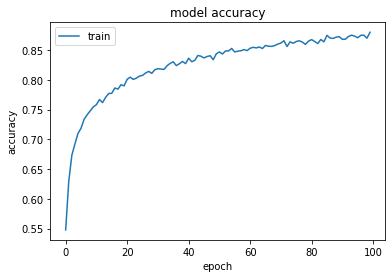

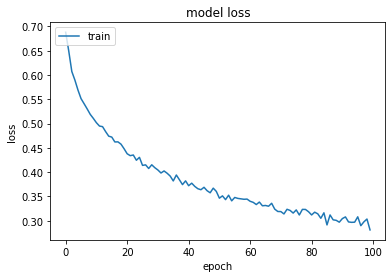

In [ ]:
import matplotlib.pyplot as plt
history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
  plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
  plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# print('id -------- label\n')
# for i in range(len(X_test)):
#     print('{},{}\n'.format(ids[i],pred[i][0]))